In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/36h11_s_z_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.421688
1,0.700996,2.290721
2,1.470014,2.230895
3,2.186581,2.162812
4,2.485063,2.080442
...,...,...
377,132.490464,10.000276
378,132.735219,10.007072
379,133.061807,10.009450
380,133.359373,9.985815


<AxesSubplot:xlabel='relative_time'>

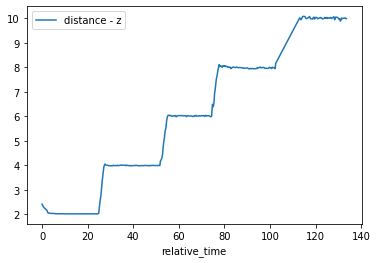

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .25)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

105

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

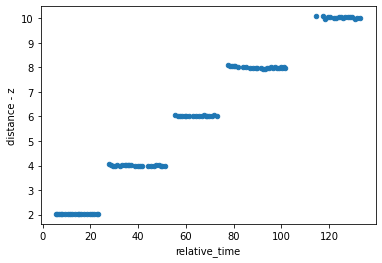

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
14,5.640791,2.038909,2
16,6.226068,2.031154,2
18,6.750744,2.028089,2
21,7.681183,2.030134,2
23,8.312802,2.029990,2
...,...,...,...
365,128.739616,10.041127,10
367,129.343154,10.045585,10
371,130.640436,9.985284,10
374,131.478717,10.009903,10


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
14,5.640791,2.038909,2,-0.038909
16,6.226068,2.031154,2,-0.031154
84,27.623237,4.055768,4,-0.055768
87,28.658978,4.009368,4,-0.009368
172,55.314700,6.043797,6,-0.043797
176,56.502320,6.038434,6,-0.038434
240,77.725833,8.109079,8,-0.109079
242,78.404778,8.066806,8,-0.066806
322,114.625316,10.077808,10,-0.077808
330,117.378235,10.072402,10,-0.072402


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,20.0,-0.029198,0.002703,-0.038909,-0.029888,-0.029018,-0.027931,-0.025818
4,24.0,-0.003390,0.012833,-0.055768,-0.007372,-0.001218,0.003898,0.012301
6,18.0,-0.030017,0.008542,-0.043797,-0.036312,-0.028639,-0.025507,-0.013583
8,26.0,0.000238,0.041557,-0.109079,-0.010343,0.007116,0.031559,0.055637
10,17.0,-0.029684,0.028080,-0.077808,-0.043651,-0.034359,-0.009903,0.025391


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

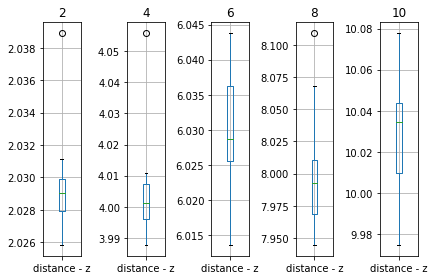

In [16]:
box_plotter(target)

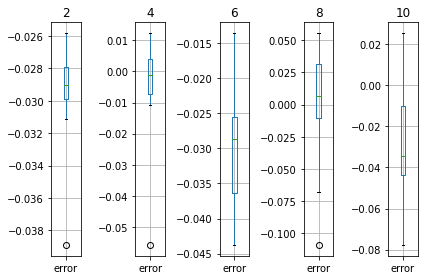

In [17]:
box_plotter('error')

In [18]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/translations/result/csv/36h11_1080.csv')